In [1]:
# conda activate chronocell

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("code"))
from protein_from_RNA import *

# sys.path.append("/mnt/lareaulab/reliscu/programs/FGP_2024")
# import Chronocell
# from Chronocell.inference import Trajectory
# from Chronocell.mixtures import PoissonMixtureSS
# from Chronocell.utils import *
# from Chronocell.plotting import *
# from Chronocell.models.two_species_ss import get_Y

In [2]:
random_seed = 666

In [3]:
# Splicing rate
beta_mu = 2
beta_sd = 0.5

# Transcription rate
alpha_mu = np.log(2) # 2
alpha_sd = 1

# Translation rate
transl_rate_mu = np.log(100)
transl_rate_sd = 1

# mRNA degradation rate
rna_median_half_life = 9
gamma_rate = np.log(2) / rna_median_half_life
gamma_mu = np.log(gamma_rate) # Median of lognormal
gamma_sd = 0.5

# Protein degradation rate
protein_median_half_life = 46
deg_rate = np.log(2) / protein_median_half_life
deg_rate_mu = np.log(deg_rate) # Median of lognormal
deg_rate_sd = 1.5

# # # Read depth
# rd_mu = 0.25
# rd_var = 1/64

In [4]:
# Simulate data

n = 2000 # No. cells per lineage
p = 500 # No. genes
topo = np.array([[0, 1, 2], [0, 1, 3]])
tau = (0, 5, 10)

theta = get_RNA_params(topo, p, alpha_mu, alpha_sd, beta_mu, beta_sd, gamma_mu, gamma_sd, random_seed=random_seed)
phi = get_protein_params(p, transl_rate_mu, transl_rate_sd, deg_rate_mu, deg_rate_sd, random_seed=random_seed)
Y_observed, Y, theta, rd, true_t, true_l = simulate_RNA(topo, tau, theta, n, random_seed=random_seed)
P_observed, P = simulate_protein_from_RNA(Y_observed, topo, true_t, true_l, phi, random_seed=random_seed)

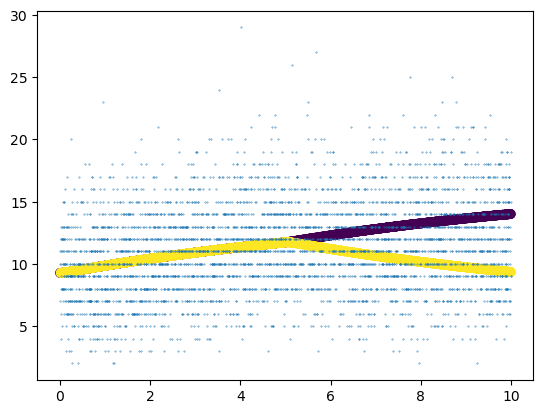

In [25]:
idx = 1
plt.scatter(true_t, Y[:, idx, 1], c=true_l)
plt.scatter(true_t, Y_observed[:, idx, 1], s=.1)

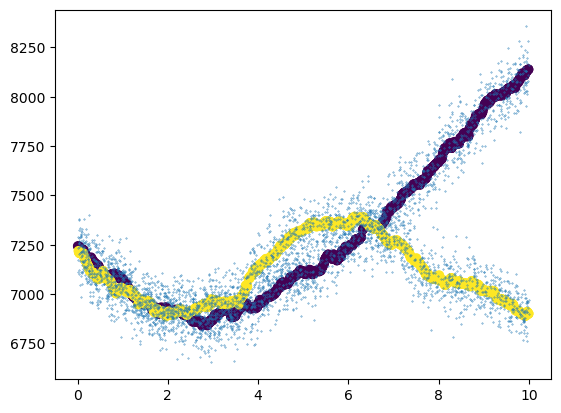

In [26]:
plt.scatter(true_t, P[:,idx], c=true_l)
plt.scatter(true_t, P_observed[:,idx], s=.1)

In [8]:
l = 0
theta_l = np.concatenate((theta[:,topo[l]], theta[:,-2:]), axis=1)

rows = []
for i in range(p):
    y_i = Y_observed[l*n:(l+1)*n, i, 1]
    p_i = P_observed[l*n:(l+1)*n, i]
    
    row = {
        'Cor': np.corrcoef(y_i, p_i)[0, 1],
        'Steady_state': theta_l[i, 0],
        'Alpha': np.mean(theta_l[i, 1:len(tau)]),
        'Beta': theta_l[i, -2],
        'Gamma': theta_l[i, -1],
        'Translation_rate': phi[i, 0],
        'Degradation_rate': phi[i, -1]
    }
    rows.append(row)
    
data = pd.DataFrame(rows)

param_cols = data.columns.values[1:data.shape[0]]

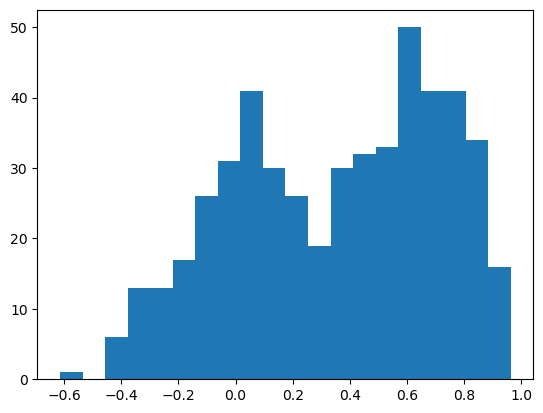

In [11]:
plt.hist(data['Cor'], bins=20);

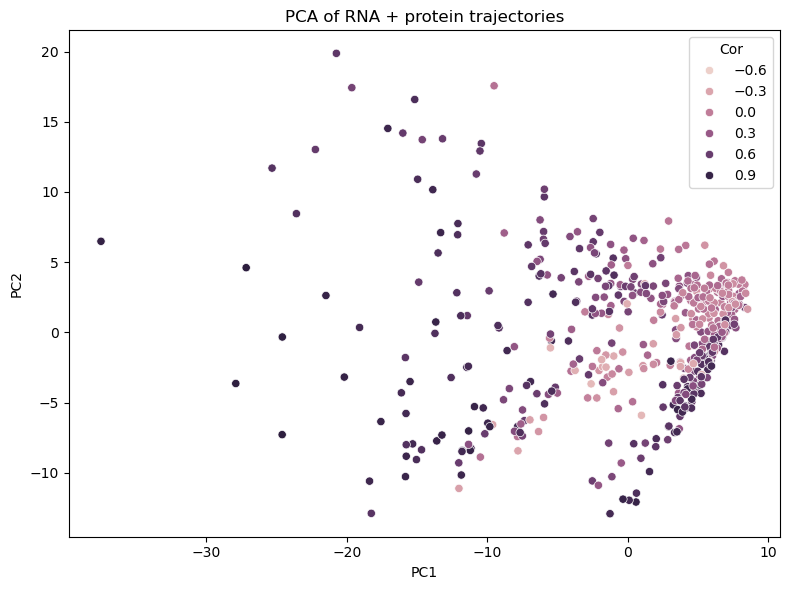

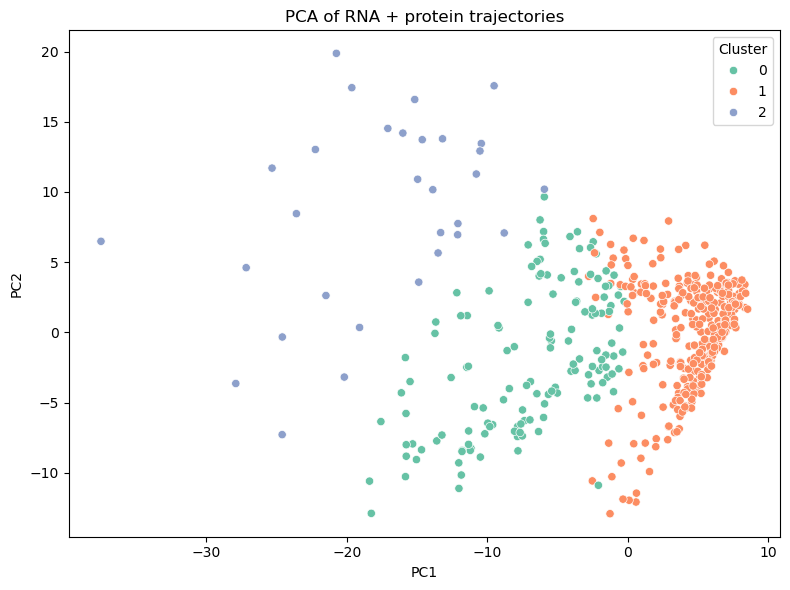

In [12]:
# PCA + Clustering + Visualization Pipeline for RNA/Protein Dynamics

np.random.seed(random_seed)

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

L = len(topo) # number of lineages
n = Y.shape[0] // L
p = Y.shape[1]

Y_traj = np.zeros((p, n))
P_traj = np.zeros((p, n))

for i in range(p):
    Y_traj[i] = Y[l*n:(l+1)*n, i, 1]/np.max(Y[l*n:(l+1)*n, i, 1])  # spliced RNA for gene i in lineage 0
    P_traj[i] = P[l*n:(l+1)*n, i]/np.max(P[l*n:(l+1)*n, i])    # protein for gene i in lineage 0

# === Step 2: Concatenate RNA and protein for PCA ===
combined_traj = np.concatenate([Y_traj, P_traj], axis=1)
pca = PCA(n_components=10)
traj_pca = pca.fit_transform(combined_traj)

# === Step 3: Clustering ===
kmeans = KMeans(n_clusters=3, random_state=0)
data['Cluster'] = kmeans.fit_predict(traj_pca)
data['PC1'] = traj_pca[:,0]
data['PC2'] = traj_pca[:,1]

# === Step 4: Visualization ===
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=data, hue='Cor')
plt.title('PCA of RNA + protein trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=data, hue='Cluster', palette='Set2')
plt.title('PCA of RNA + protein trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()


              Cor  Steady_state     Alpha      Beta     Gamma  \
Cluster                                                         
1        0.272234      0.650455  0.382998  8.153756  0.080176   
0        0.464065      0.191017  0.632839  8.382485  0.089827   
2        0.715687      0.102572  1.281732  7.970075  0.102255   

         Translation_rate  Degradation_rate        PC1       PC2  
Cluster                                                           
1              172.394648          0.045641   4.525123 -0.007413  
0              157.111216          0.027436  -6.769214 -1.893866  
2              129.188138          0.129158 -17.454046  8.631617  


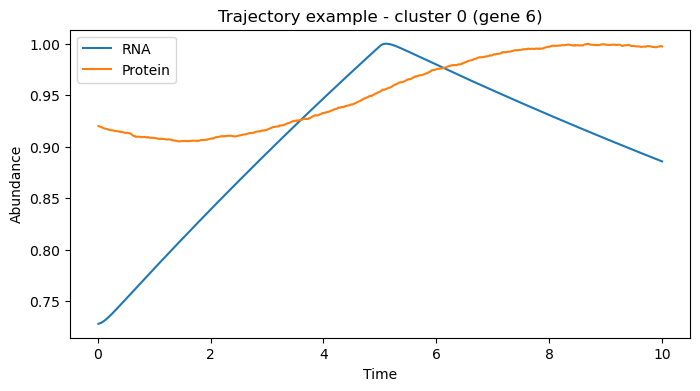

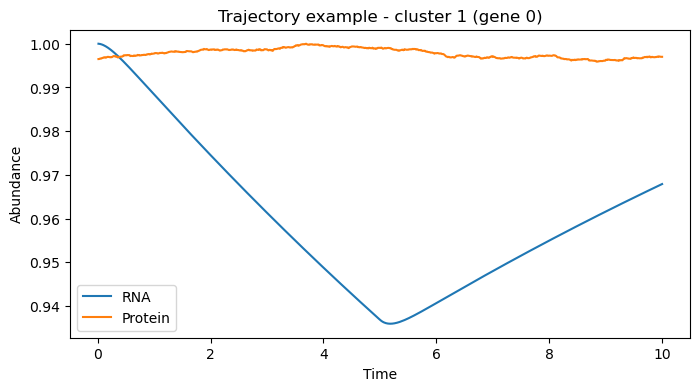

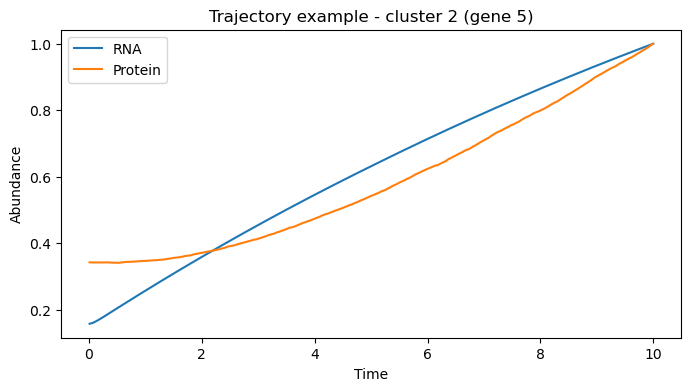

In [28]:
# === Step 5: Correlation Summary by Cluster ===
print(data.groupby('Cluster').mean().sort_values('Cor'))

# Plot representative gene trajectories from each cluster
for c in sorted(data['Cluster'].unique()):
    idx = data[data['Cluster'] == c].index[0]  # random gene in cluster
    plt.figure(figsize=(8, 4))
    plt.plot(true_t[true_l == l], Y[l*n:(l+1)*n, idx, 1]/np.max(Y[l*n:(l+1)*n, idx, 1]), label='RNA')
    plt.plot(true_t[true_l == l], P[l*n:(l+1)*n, idx]/np.max(P[l*n:(l+1)*n, idx]), label='Protein')
    plt.title(f'Trajectory example - cluster {c} (gene {idx})')
    plt.xlabel('Time')
    plt.ylabel('Abundance')
    plt.legend()
    plt.show()

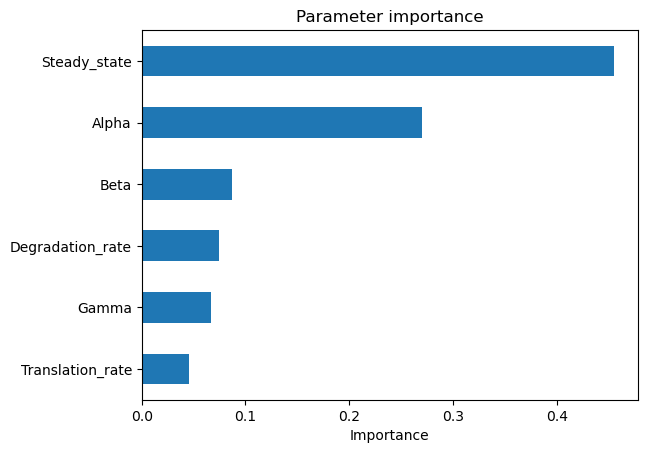

In [30]:
from sklearn.ensemble import RandomForestClassifier

X_params = data[param_cols]
y_clusters = data['Cluster']

clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_params, y_clusters)

importances = pd.Series(clf.feature_importances_, index=param_cols)
importances.sort_values(ascending=True).plot(kind='barh')
plt.title("Parameter importance")
plt.xlabel("Importance")
plt.show()

In [ ]:
sns.pairplot(data, vars=['Steady_state', 'Alpha', 'Gamma', 'Translation_rate', 'Degradation_rate', 'Cor'], hue='Cor', palette='viridis')

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay

X = data[param_cols]
y = data['Cor']

model = RandomForestRegressor(n_estimators=100, max_depth=len(param_cols), random_state=0)
model.fit(X, y)

RandomForestRegressor(max_depth=6, random_state=0)

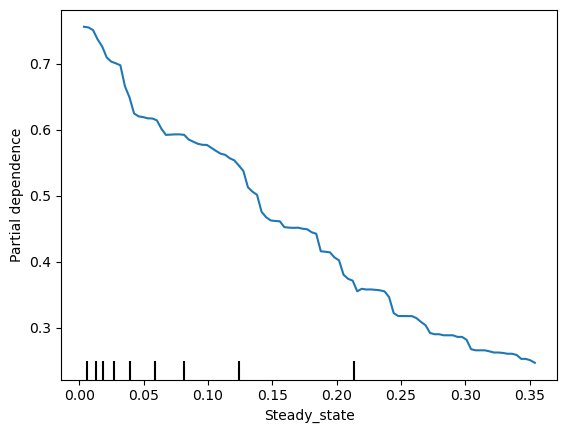

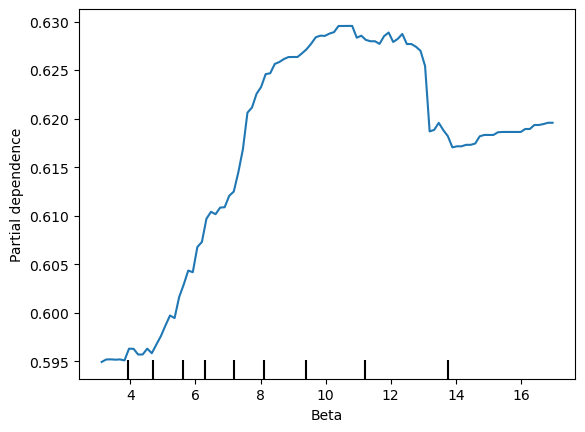

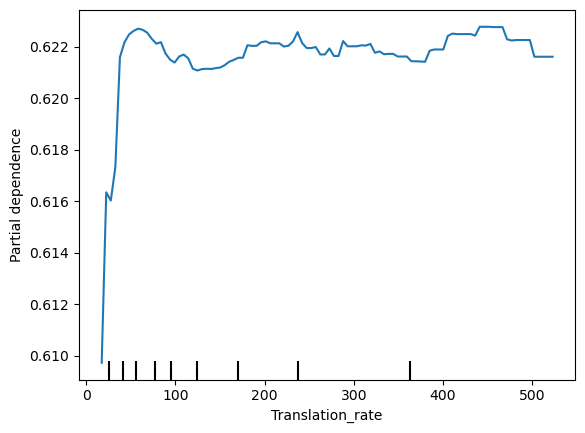

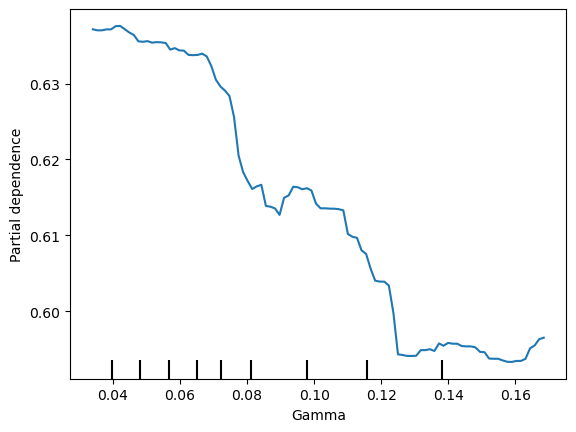

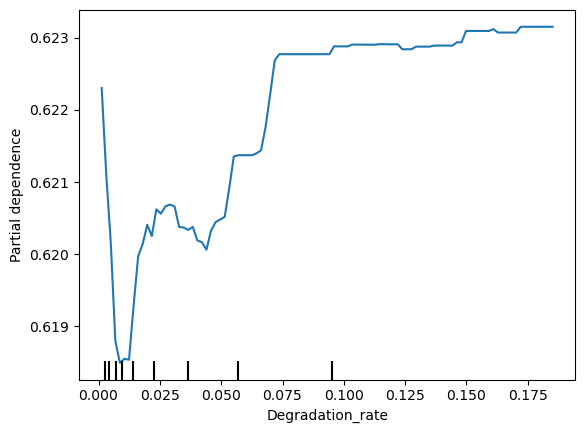

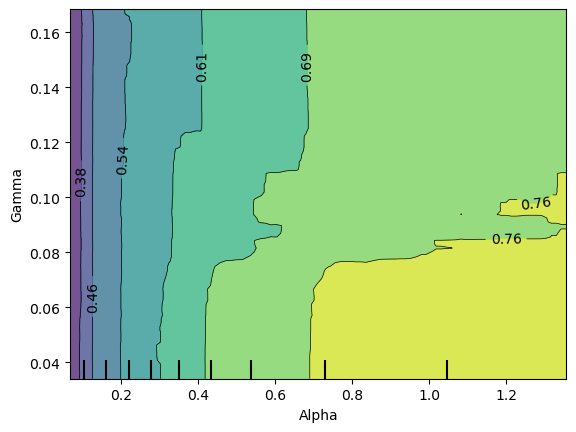

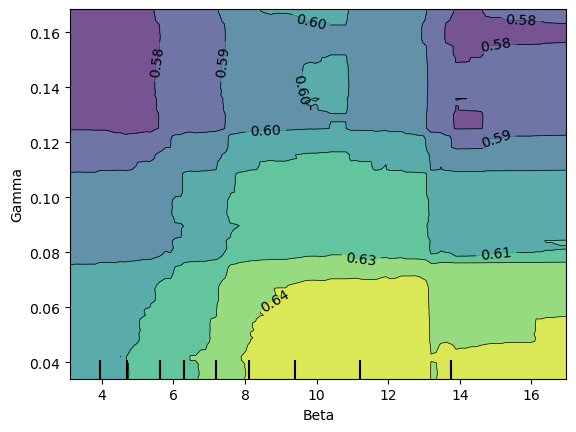

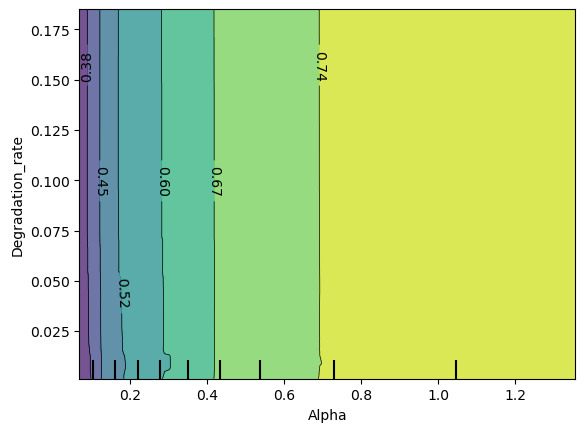

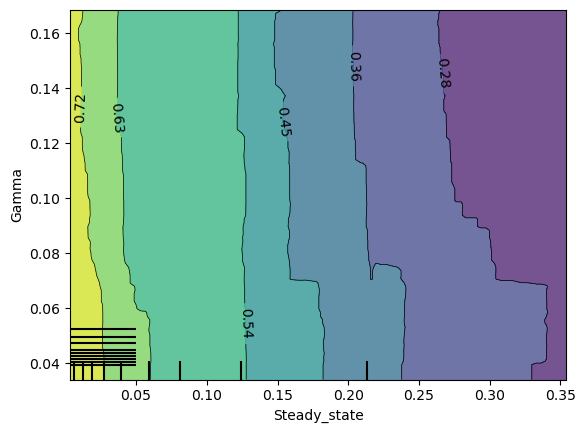

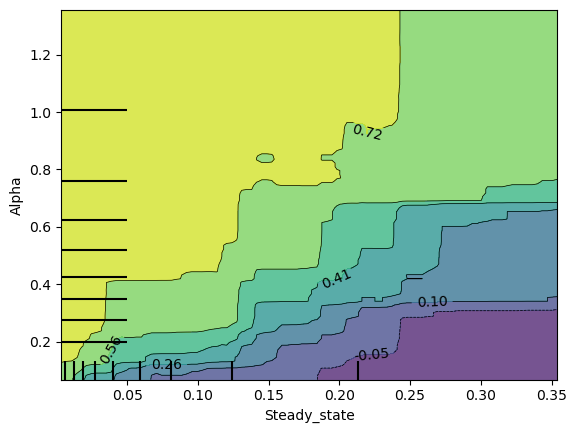

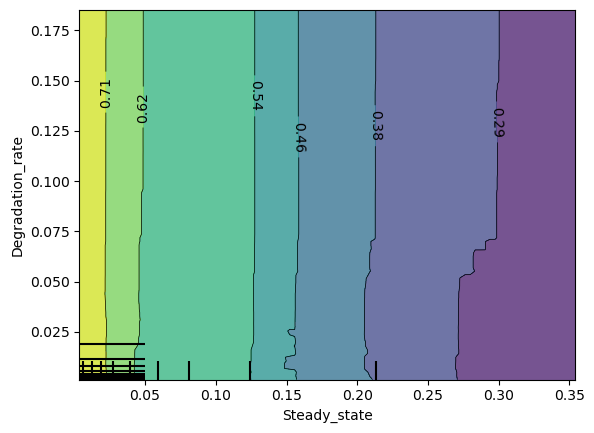

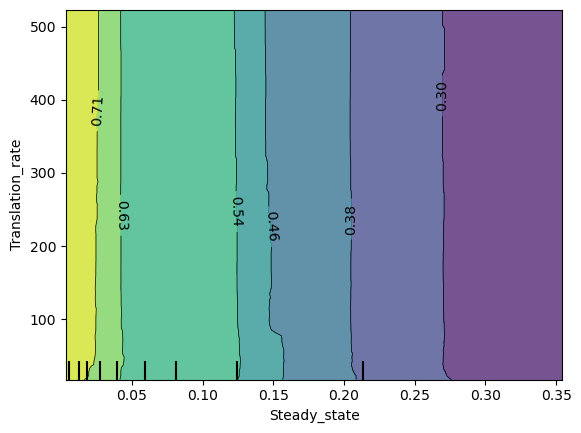

In [16]:
# PDP plots

PartialDependenceDisplay.from_estimator(model, X, features=['Steady_state'])
PartialDependenceDisplay.from_estimator(model, X, features=['Beta'])
PartialDependenceDisplay.from_estimator(model, X, features=['Translation_rate'])
PartialDependenceDisplay.from_estimator(model, X, features=['Gamma'])
PartialDependenceDisplay.from_estimator(model, X, features=['Degradation_rate'])

PartialDependenceDisplay.from_estimator(model, X, features=[('Alpha', 'Gamma')])
plt.show()
PartialDependenceDisplay.from_estimator(model, X, features=[('Beta', 'Gamma')])
plt.show()
PartialDependenceDisplay.from_estimator(model, X, features=[('Alpha', 'Degradation_rate')])
plt.show()
PartialDependenceDisplay.from_estimator(model, X, features=[('Steady_state', 'Gamma')])
plt.show()
PartialDependenceDisplay.from_estimator(model, X, features=[('Steady_state', 'Alpha')])
plt.show()
PartialDependenceDisplay.from_estimator(model, X, features=[('Steady_state', 'Degradation_rate')])
plt.show()
PartialDependenceDisplay.from_estimator(model, X, features=[('Steady_state', 'Translation_rate')])
plt.show()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=1, include_bias=False)
X_poly = poly.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, y)

# Get interaction term names
feature_names = poly.get_feature_names_out(X.columns)
coeffs = pd.Series(model.coef_, index=feature_names).sort_values(key=abs, ascending=False)
print(coeffs.head(15))

Gamma^2                          3.692642
Gamma Degradation_rate          -2.612073
Gamma                           -1.624578
Degradation_rate                 0.426640
Degradation_rate^2               0.278358
Steady_state Gamma              -0.200914
Alpha Gamma                     -0.095976
Alpha                            0.057834
Alpha Degradation_rate           0.038934
Steady_state Degradation_rate   -0.038243
Beta Degradation_rate           -0.033236
Steady_state                    -0.024323
Beta                             0.021282
Beta Gamma                      -0.017003
Steady_state Alpha               0.003892
dtype: float64


In [ ]:
# Range of gamma values
gamma_range = np.linspace(data['Gamma'].min(), data['Gamma'].max(), 200)

# Reconstruct prediction manually (using fitted coefficients)
# This assumes you know the indices or names of your Gamma and Gamma^2 terms
beta_linear = coeffs.get('Gamma', 0)
beta_quad = coeffs.get('Gamma^2', 0)
intercept = model.intercept_

cor_pred = intercept + beta_linear * gamma_range + beta_quad * gamma_range**2

plt.plot(gamma_range, cor_pred)
plt.xlabel('Gamma (RNA degradation rate)')
plt.ylabel('Predicted Correlation')
plt.title('Quadratic Effect of Gamma on RNA–Protein Correlation')
plt.show()


/mnt/lareaulab/reliscu/anaconda3/envs/chronocell/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


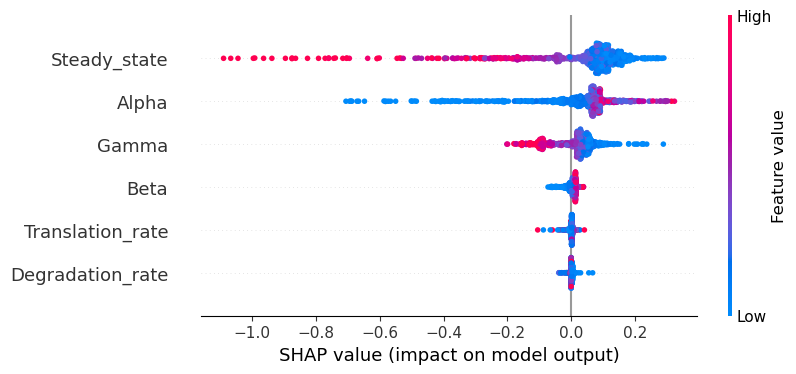

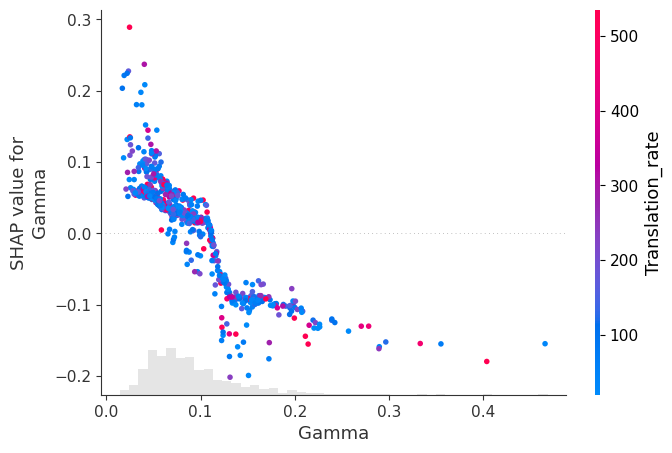

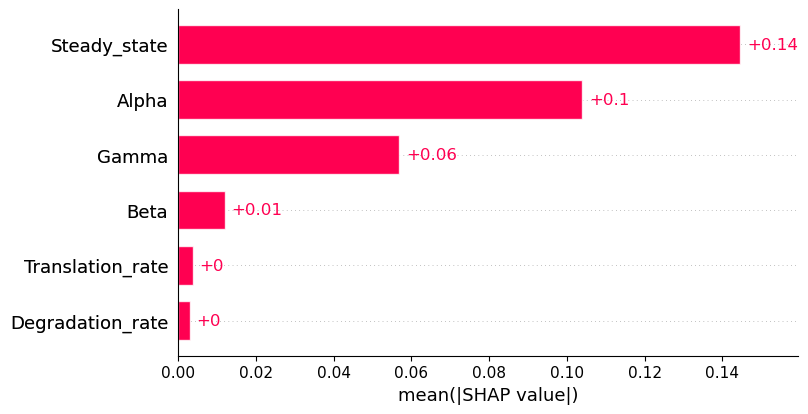

In [42]:
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 1. Prepare features and target
X = data[param_cols]
y = data['Cor']

# 2. Train/test split (optional but recommended for evaluation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 3. Fit Random Forest
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
model.fit(X_train, y_train)

# 4. Create SHAP explainer with new API
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)  # Explanation object

# 5. Plot summary (beeswarm)
shap.plots.beeswarm(shap_values, max_display=10)

# 6. Plot dependence (e.g. Gamma vs Cor, colored by Translation_rate)
shap.plots.scatter(shap_values[:, "Gamma"], color=shap_values[:, "Translation_rate"])

# 7. If you want bar plot of mean |SHAP| values:
shap.plots.bar(shap_values, max_display=10)
